<b>HW 6: Character classification using CNN with PyTorch

Author:
</b> Brian Erichsen Fagundes


In [1]:
# Step 1: Data acquision + clenup
import pandas as pd
import numpy as np

# loads data into variable
data = pd.read_csv('ARIAL.csv')

# lets filter out non printable graphic characters // between 33 to 126
data = data[(data['m_label'] > 32) & (data['m_label'] < 127)]

# selects which columns to keep m_label and all the r{x} c{y}
columns_to_keep = ['m_label']
columns_to_keep += [f'r{r}c{c}' for r in range(0, 20) for c in range(0, 20)]
filtered_data = data[columns_to_keep]

# funtion that transforms dataframe returns 2 numpy arrays
# x sample x 20 x 20 has pixel val, y #samples x 1 array has ascii for each char
def transform_data(data_frame):
    # extract the pixel val and normalize data
    # . values converts from pandas to numpy array
    Xs = data_frame[[f'r{r}c{c}' for r in range(0, 20) for c in range(0, 20)]].values
    # makes it samples x 20 x 20 D / 256.0
    Xs = Xs.reshape(-1, 20, 20) / 256.0

    # extrac the ascii value for each char
    Ys = data_frame['m_label'].values
    # makes samples# x 1 Dim
    Ys = Ys.reshape(-1, 1)

    return Xs, Ys

Xs, Ys = transform_data(filtered_data)

# dictionary for label conversion - using set (collection of unique elements)
unique_chars = sorted(set(filtered_data['m_label']))
# maps each char to unique index
char_to_index = {char: idx for idx, char in enumerate(unique_chars)}
# maps each index back to char
index_to_char = {idx: char for char, idx in char_to_index.items()}

# convert labels to indices
Ys = np.array([char_to_index[char] for char in Ys.flatten()])

<b>Step 2: Build a Pytorch network</b>

In [2]:
# Step 2: Build a Pytorch network where its archecture is
    # Convolution 2D layer (relu)
    # Max pooling layer
    # Convolution, another Max pooling
    # Dense layer (relu), dense layer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

# Tensor is numpy multi dim array
# Convert data to PyTorch tensors
Xs = torch.tensor(Xs, dtype=torch.float32).reshape(-1, 1, 20, 20) # between 0 and 1
Ys = torch.tensor(Ys, dtype=torch.long) # can be long int

# So we can iterate over batches
dataset = TensorDataset(Xs, Ys)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Network as a class with a constructor and forward method
class Net(nn.Module):
    def __init__(self):
        # parent class
        super(Net, self).__init__()
        # 1d input, 6 outputs and 3 x 3 pixels kernel filter
        self.conv1 = nn.Conv2d(1, 6, 3)
        # kernel size of 2, reduces spatial dim by half, with stride of 2 for 2x2 kernel
        self.pool = nn.MaxPool2d(2, 2)
        #conv1 output - ((input size - kernel size + 2 x Padding) / Stride)+1
        # 20 - 3 / 1 + 1 -- 18 x 18
        # after first pooling -- 9 x 9 size instead of 18 x 18
        # 6 from the 6 output layer in the 1st convolution layer
        self.conv2 = nn.Conv2d(6, 16, 3)
        # 9 - 3 / 1 + 1 -- 7 x 7
        # after second layer of pooling - 3 x 3
        # first dense layer has 16 * 3 * 3 input features and 120 neurons (output features)
        # after second pooling layer, we have 16 channels 3 x 3
        self.fc1 = nn.Linear(16 * 3 * 3, 120)
        #self.fc2 = nn.Linear(120, 84)
                            # (84, num of classes)
        self.fc3 = nn.Linear(120, len(unique_chars))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))# conv1 -> relu -> max pool
        x = self.pool(F.relu(self.conv2(x)))# conv2 -> relu -> max pool
        x = x.view(-1, 16 * 3 * 3)# flattens the tensor back to 1 D
        x = F.relu(self.fc1(x)) # FC1 -> relu
        #x = F.relu(self.fc2(x)) # FC2 -> relu
        x = self.fc3(x) # last dense layer
        return x
    
    # Initialize model, loss function, and optimizer
# remember that cuda is using GPU with parallelism
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
net = Net().to(device)
# measures error for classification
criterion = nn.CrossEntropyLoss()
# uses ADAM optimizer to find the best weights
optmizer = optim.Adam(net.parameters(), lr=0.001)

# training function
def train(model,train_loader, optmizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            # move tensors to specific machine (CPU / GPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the param gradients
            optmizer.zero_grad()
            outputs = model(inputs) # predict the output with training data
            loss = criterion(outputs, labels) # see how well we did
            loss.backward() # see how to change weight to do better
            optmizer.step() # actually changes the weights
            running_loss += loss.item()
            # prints every 200 batch statistics
            if i % 200 == 199:
                print(f'Epoch [{epoch + 1}], Step [{i + 1}], Loss: {running_loss / 200:.4f}')
                running_loss = 0.0
    print('Finished Training')

train(net,train_loader, optmizer, criterion, 4)

Epoch [1], Step [200], Loss: 2.2737
Epoch [2], Step [200], Loss: 0.5640
Epoch [3], Step [200], Loss: 0.3093
Epoch [4], Step [200], Loss: 0.2276
Finished Training


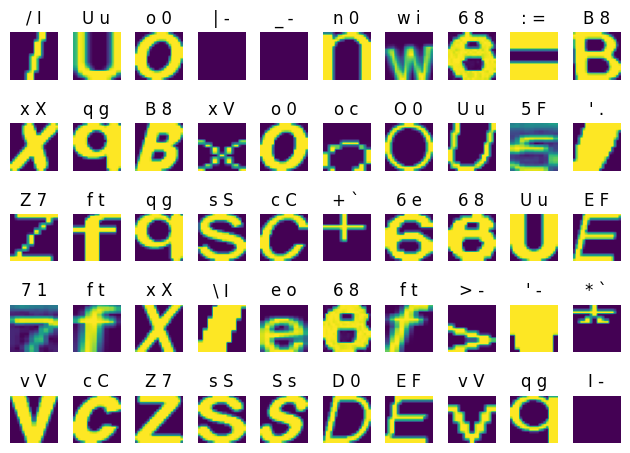

Accuracy of the network: 92.84%


In [3]:
# Evaluate function
import matplotlib.pyplot as plt

def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    incorrect = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device).view(-1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            for i in range(len(labels)):
                # compares true label of i-th image with predicted of i-th
                if predicted[i] != labels[i]:
                    ascii_label = chr(index_to_char[labels[i].item()])
                    predicted_label = chr(index_to_char[predicted[i].item()])
                    plt.subplot(5, 10, incorrect + 1)
                    plt.imshow(images[i, 0].cpu())
                    plt.title(f'{ascii_label} {predicted_label}')
                    plt.axis('off')

                    incorrect += 1
                    if incorrect >= 50:
                        break
            if incorrect >= 50:
                break

    plt.tight_layout()
    plt.show()
    print(f'Accuracy of the network: { 100 * correct / total:.2f}%')

evaluate(net)

On the plotted image; we are plotting the image that the NN processed for that input where 1st title is the true label of given input and the second is the predicted label of given input.

<b>Step 3: Exploration and Evaluation</b>

In [4]:
# Evaluate the network using cross validation
# (splitting data into training/testing). What is its accuracy?

from sklearn.model_selection import train_test_split
# random number is arbitrary
x_train, x_test, y_train, y_test = train_test_split(Xs, Ys, test_size=0.5, random_state=42)
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, drop_last=True)

# function to properly train NN and do a Evaluation with Cross-Validation
def validade_CV(model, test_dataset):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device).view(-1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(test_dataset)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {accuracy:.2f}%')

In [5]:
train(net,train_loader, optmizer, criterion , 4)
validade_CV(net, test_loader)

Finished Training
Validation Loss: 94.67%


In [6]:
# Lets create and train a different topology, adding more convolutiuon layers
class NetImproved(nn.Module):
    def __init__(self):
        super(NetImproved, self).__init__()
        a = 1 # solve for a ...
        # 1d input, 6 outputs and 3 x 3 pixels kernel filter
        c1Out = 6
        c2Out = 16
        c3Out = 32
        self.conv1 = nn.Conv2d(1, c1Out, 3)
        # convoluted layer 1 output -> 20 - 3 + 1 --18 x 18
        # first pooling layer -- 9 x 9
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3)
        # convoluted layer 2 output -> 9 - 3 + 1 -- 7 x 7
        # second pooling layer -- 3 x 3
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(c2Out, c3Out, 3)
        # convoluted layer 3 output -> 3 - 3 + 1 -- 1
        self.pooledOutputSize = c3Out * a * a
        #self.fc1 = nn.Linear(self.pooledOutputSize, 120)
        self.fc1 = nn.Sequential(
            nn.Linear(self.pooledOutputSize, 120),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, len(unique_chars)),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.pooledOutputSize)
        x = F.relu(self. fc1(x))
        x = self.fc2(x)

        return x

net_improved = NetImproved().to(device)
optimizer_improved = optim.Adam(net_improved.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


Finished Training
Validation Loss: 86.06%


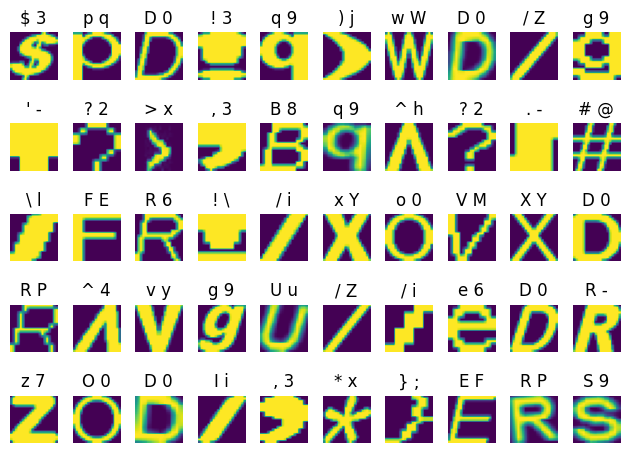

Accuracy of the network: 85.23%


In [7]:
train(net_improved,train_loader, optimizer_improved, criterion, 10)
validade_CV(net_improved, test_loader)
evaluate(net_improved)

In [8]:
# Lets try a different topology since the previous attempt yielded a low
# Here I used same number of convoluted layers and fully connected layers as well
# but added batch normalization for stabalize and accelerate training
# and dropout as well after each FC layer to prevent overfitting

# Network as a class with a constructor and forward method
class NetImproved2(nn.Module):
    def __init__(self):
        # parent class
        super(NetImproved2, self).__init__()
        # 1d input, 6 outputs and 3 x 3 pixels kernel filter
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.batch_norm1 = nn.BatchNorm2d(6)
        # kernel size of 2, reduces spatial dim by half, with stride of 2 for 2x2 kernel
        self.pool = nn.MaxPool2d(2, 2)
        #conv1 output - ((input size - kernel size + 2 x Padding) / Stride)+1
        # 20 - 3 / 1 + 1 -- 18 x 18
        # after first pooling -- 9 x 9 size instead of 18 x 18
        # 6 from the 6 output layer in the 1st convolution layer
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.batch_norm2 = nn.BatchNorm2d(16)
        # 9 - 3 / 1 + 1 -- 7 x 7
        # after second layer of pooling - 3 x 3
        # first dense layer has 16 * 3 * 3 input features and 120 neurons (output features)
        # after second pooling layer, we have 16 channels 3 x 3
        self.fc1 = nn.Linear(16 * 3 * 3, 120)
        #self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(120, len(unique_chars))
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))# conv1 -> relu -> max pool
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))# conv2 -> relu -> max pool
        x = x.view(-1, 16 * 3 * 3)# flattens the tensor back to 1 D
        x = self.dropout(F.relu(self.fc1(x))) # FC1 -> relu
        #x = F.relu(self.fc2(x)) # FC2 -> relu
        x = self.fc3(x) # last dense layer
        return x

net_improved = NetImproved2().to(device)
optimizer_improved = optim.Adam(net_improved.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


Finished Training
Validation Loss: 94.65%


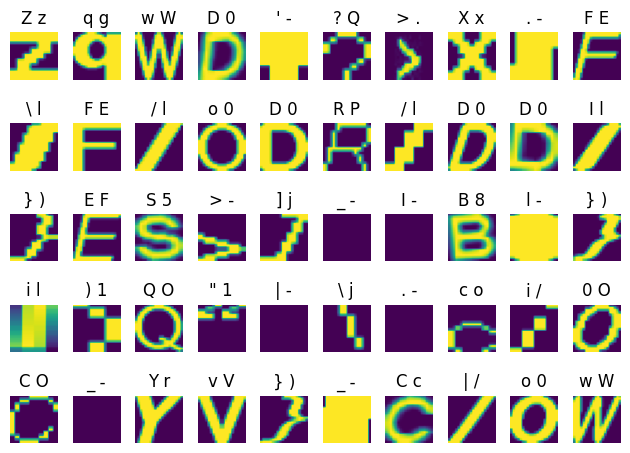

Accuracy of the network: 93.63%


In [9]:
train(net_improved,train_loader, optimizer_improved, criterion, 10)
validade_CV(net_improved, test_loader)
evaluate(net_improved)

By adding batch normalization for stabalization and to accelerate training

along with dropout as well after each fully connected layer to prevent overfitting we were

able to increase accuracy of the network from 92.84% to 94.65%.

In [10]:
# Lets try a slightly different topology using bigger kernel size for
# the convolution layers


# Network as a class with a constructor and forward method
class NetImproved3(nn.Module):
    def __init__(self):
        # parent class
        super(NetImproved3, self).__init__()
        # 1d input, 6 outputs and 5 x 5 pixels kernel filter
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.batch_norm1 = nn.BatchNorm2d(6)
        # kernel size of 2, reduces spatial dim by half, with stride of 2 for 2x2 kernel
        self.pool = nn.MaxPool2d(2, 2)
        #conv1 output - ((input size - kernel size + 2 x Padding) / Stride)+1
        # 20 - 5 / 1 + 1 -- 16 x 16
        # after first pooling -- 8 x 8 size instead of 16 x 16
        # 6 from the 6 output layer in the 1st convolution layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batch_norm2 = nn.BatchNorm2d(16)
        # 8 - 5 / 1 + 1 -- 4 x 4
        # after second layer of pooling - 2 x 2
        # first dense layer has 16 * 3 * 3 input features and 120 neurons (output features)
        # after second pooling layer, we have 16 channels 3 x 3
        self.fc1 = nn.Linear(16 * 2 * 2, 120)
        #self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(120, len(unique_chars))
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))# conv1 -> relu -> max pool
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))# conv2 -> relu -> max pool
        x = x.view(-1, 16 * 2 * 2)# flattens the tensor back to 1 D
        x = self.dropout(F.relu(self.fc1(x))) # FC1 -> relu
        #x = F.relu(self.fc2(x)) # FC2 -> relu
        x = self.fc3(x) # last dense layer
        return x

net_improved = NetImproved3().to(device)
optimizer_improved = optim.Adam(net_improved.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Finished Training
Validation Loss: 94.56%


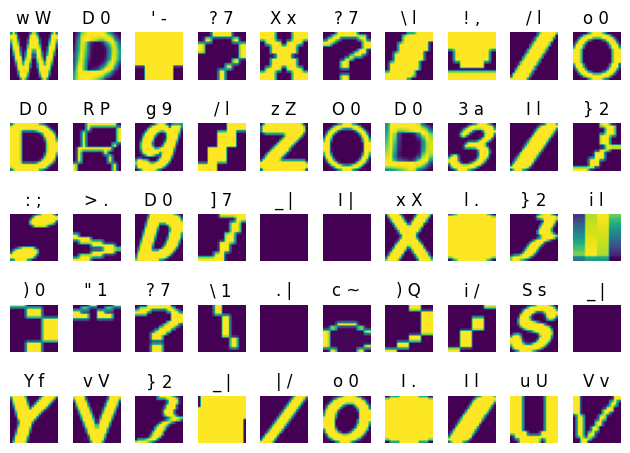

Accuracy of the network: 93.99%


In [11]:
train(net_improved,train_loader, optimizer_improved, criterion, 10)
validade_CV(net_improved, test_loader)
evaluate(net_improved)

By increasing the filter size used in the convoluted layers we maintained about the same level of accuracy.

Lets test the accuracy with char inputs from different front set and see how it performs

Finished Training
Validation Loss: 93.37%


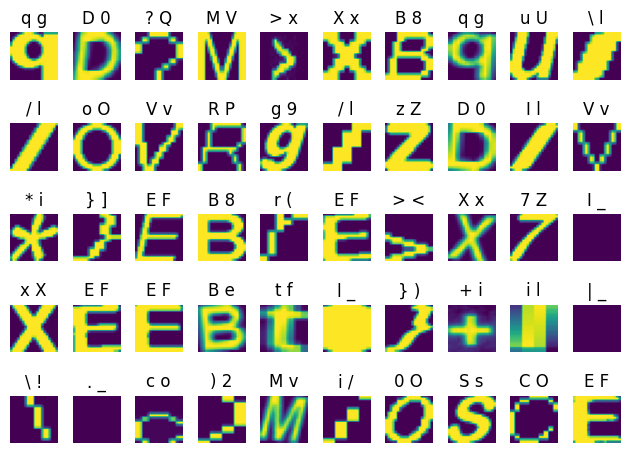

Accuracy of the network: 93.21%


In [12]:
# Here we load ARIAL data into model and check accuracy for comparison

# loads data into variable
data = pd.read_csv('ARIAL.csv')

# lets filter out non printable graphic characters // between 33 to 126
data = data[(data['m_label'] > 32) & (data['m_label'] < 127)]

# selects which columns to keep m_label and all the r{x} c{y}
columns_to_keep = ['m_label']
columns_to_keep += [f'r{r}c{c}' for r in range(0, 20) for c in range(0, 20)]
filtered_data = data[columns_to_keep]

Xs, Ys = transform_data(filtered_data)

# convert labels to indices
Ys = np.array([char_to_index[char] for char in Ys.flatten()])

# Tensor is numpy multi dim array
# Convert data to PyTorch tensors
Xs = torch.tensor(Xs, dtype=torch.float32).reshape(-1, 1, 20, 20) # between 0 and 1
Ys = torch.tensor(Ys, dtype=torch.long) # can be long int

# random number is arbitrary
x_train, x_test, y_train, y_test = train_test_split(Xs, Ys, test_size=0.5, random_state=42)
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, drop_last=True)

    # Initialize model, loss function, and optimizer
# remember that cuda is using GPU with parallelism
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
net = Net().to(device)
# measures error for classification
criterion = nn.CrossEntropyLoss()
# uses ADAM optimizer to find the best weights
optimizer = optim.Adam(net.parameters(), lr=0.001)

train(net, train_loader, optimizer, criterion, 10)
validade_CV(net, test_loader)
evaluate(net)

Using the different font set TIMES instead of ARIAL, using the 1st topology of NN the accuracy of the model seemed to decrease accuracy slightly to when training with arial instead.

Finished Training
Validation Loss: 93.58%


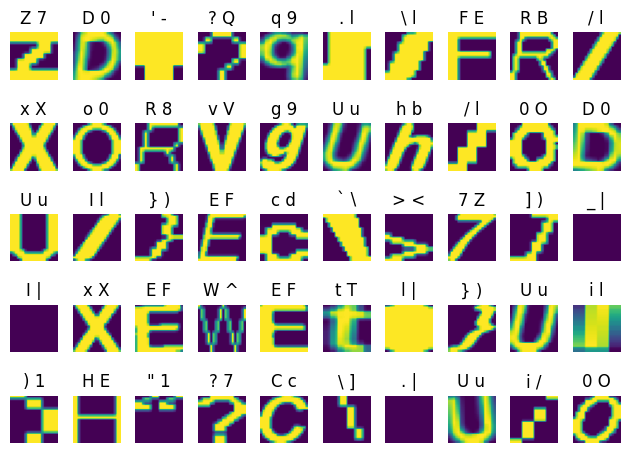

Accuracy of the network: 92.90%
Finished Training
Validation Loss: 94.67%


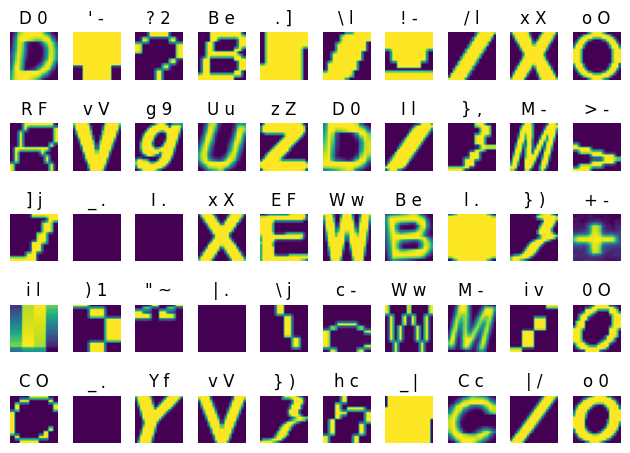

Accuracy of the network: 93.75%


In [13]:
net_improved = NetImproved2().to(device)
optimizer_improved = optim.Adam(net_improved.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train(net_improved,train_loader, optimizer_improved, criterion, 10)
validade_CV(net_improved, test_loader)
evaluate(net_improved)

net_improved = NetImproved3().to(device)
optimizer_improved = optim.Adam(net_improved.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train(net_improved,train_loader, optimizer_improved, criterion, 10)
validade_CV(net_improved, test_loader)
evaluate(net_improved)

Lets try to see some results with training the NN with 2 different fonts.

Finished Training
Validation Loss: 91.71%


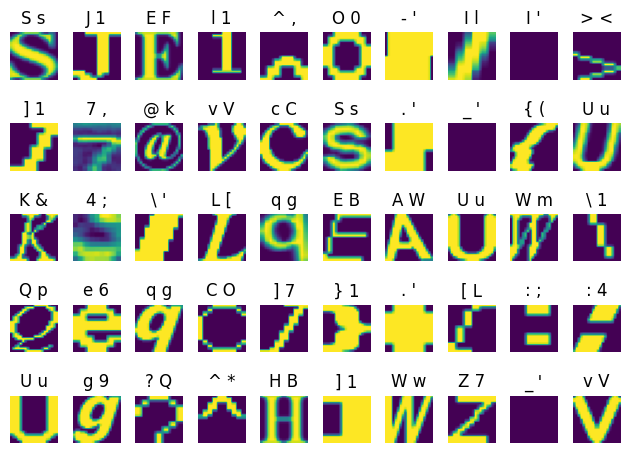

Accuracy of the network: 90.97%


In [14]:
# concatenate both files data
arial_data = pd.read_csv('ARIAL.csv')
times_data = pd.read_csv('TIMES.csv')

data = pd.concat([arial_data, times_data])

# lets filter out non printable graphic characters // between 33 to 126
data = data[(data['m_label'] > 32) & (data['m_label'] < 127)]


# selects which columns to keep m_label and all the r{x} c{y}
columns_to_keep = ['m_label']
columns_to_keep += [f'r{r}c{c}' for r in range(0, 20) for c in range(0, 20)]
filtered_data = data[columns_to_keep]

Xs, Ys = transform_data(filtered_data)
# convert labels to indices
Ys = np.array([char_to_index[char] for char in Ys.flatten()])

# Convert data to PyTorch tensors
Xs = torch.tensor(Xs, dtype=torch.float32).reshape(-1, 1, 20, 20) # between 0 and 1
Ys = torch.tensor(Ys, dtype=torch.long) # can be long int

x_train, x_test, y_train, y_test = train_test_split(Xs, Ys, test_size=0.5, random_state=42)
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, drop_last=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
net = Net().to(device)
# measures error for classification
criterion = nn.CrossEntropyLoss()
# uses ADAM optimizer to find the best weights
optimizer = optim.Adam(net.parameters(), lr=0.001)

train(net, train_loader, optimizer, criterion, 10)
validade_CV(net, test_loader)
evaluate(net)

The accuracy of the NN over from training from at least 2 inputs of fonts did not seem to increase the accuracy of the model. One explanation for such may be possible noise in the fed data into the NN. Noise in the data can potentially make the model less accurate.

The pattern that seems to be prevalent among the the different models in misclassifiying character seems to be confusing lower capital letters with capital letters, or similar letters (i.e. F - E) or letters that resemble numbers (i.e. g - 9).

<b>Step 4: Denoising</b>

In [15]:
# NN class where we mix Convoluted layers with autoencoders for dimension reduction
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encodedSize = 32

        self.c1Out = 8 #Number of output Neurons for 1st Convoluted layer
        self.c2Out = 8 #Number of output Neurons for 1st Convoluted layer
        # sets 1st convoluted layer
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2) # pooling layer between convoluted layers
        
        # sets 2nd convoluted layer
        self.cv2 =  nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1)
        # note that we have 4 fully connected layers
        self.downscaledSize = 20//4 #round to nearest down digit
        self.flattenedSize = self.downscaledSize*self.downscaledSize*self.c2Out

        # sets all 4 fully connected layers
        self.fc1 = nn.Linear(self.flattenedSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize)
        self.fc3 = nn.Linear(self.encodedSize, 64)
        self.fc4 = nn.Linear(64, self.flattenedSize)

        # sets the upsample to decode and last 2 convoluted layers
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)

    def compress(self, x):
        x = self.cv1(x)
        x = F.relu(self.pool(x))

        x = self.cv2(x)
        x = F.relu(self.pool(x))

        x = x.view(-1, self.flattenedSize)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x
    
    def decompress(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        x = self.upsample(x)
        x = F.relu(self.cv3(x))
        x = self.cv4(self.upsample(x))
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)

        return x
    

In [16]:
# similar to previous train method
def train_autoencoder(model, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        loss = 0
        running_loss = 0

        for i, data in enumerate(train_loader, 0):
            noisy_images, clean_images = data
            noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
            optimizer.zero_grad()
            outputs = model(noisy_images)
            train_loss = criterion(outputs, clean_images)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()
            running_loss += train_loss.item()

            if i % 200 == 199:
                print(f'Epoch [{epoch+1}], Step [{i+1}], Loss: {running_loss / 200:.4f}')
                running_loss = 0.0
        loss = loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}')
    print('Finished Training')

In [17]:
def evaluate_autoencoder(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            noisy_images, clean_images = data
            noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
            outputs = model(noisy_images)
            test_loss = criterion(outputs, clean_images)
            total_loss += test_loss.item()
            
    print(f'Overall Loss: {(total_loss / len(test_loader)):.4f}%')

# method to add guassian noise into images input
def add_noise(images, noise_factor):
    # rand_like retuns tensor same size filled with random numbers from normal distribution with mean 0 and variance 1
    noisy_images = images + noise_factor * torch.randn_like(images)
    # clamp (input, min, max)
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images


In [20]:
# loads data into variable
data = pd.read_csv('ARIAL.csv')

# lets filter out non printable graphic characters // between 33 to 126
#data = data[(data['m_label'] > 32) & (data['m_label'] < 127)]

# selects which columns to keep m_label and all the r{x} c{y}
columns_to_keep = ['m_label']
columns_to_keep += [f'r{r}c{c}' for r in range(0, 20) for c in range(0, 20)]
filtered_data = data[columns_to_keep]

Xs, Ys = transform_data(filtered_data)

# convert labels to indices
#Ys = np.array([char_to_index[char] for char in Ys.flatten()])

# Tensor is numpy multi dim array
# Convert data to PyTorch tensors
Xs = torch.tensor(Xs, dtype=torch.float32).reshape(-1, 1, 20, 20) # between 0 and 1
Ys = torch.tensor(Ys, dtype=torch.long) # can be long int

noisy_Xs = add_noise(Xs, noise_factor=0.5)

# random number is arbitrary
# added x train noisy and x test noisy - so we use noisy images as input and expected output clean outputs
x_train_noisy, x_test_noisy, x_train_clean, x_test_clean, y_train, y_test = train_test_split(noisy_Xs ,Xs, Ys, test_size=0.5, random_state=42)
train_data = TensorDataset(x_train_noisy, x_train_clean)
test_data = TensorDataset(x_test_noisy, x_test_clean)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, drop_last=True)

    # Initialize model, loss function, and optimizer
# remember that cuda is using GPU with parallelism
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
autoencoder = AutoEncoder().to(device)
# measures error for classification
criterion = nn.MSELoss()
# uses ADAM optimizer to find the best weights
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


train_autoencoder(autoencoder, train_loader, optimizer, criterion, 10)
evaluate_autoencoder(autoencoder, test_loader, criterion)

Epoch [1], Step [200], Loss: 0.1775
Epoch [1], Step [400], Loss: 0.1218
Epoch [1/10], Loss: 0.1487
Epoch [2], Step [200], Loss: 0.1039
Epoch [2], Step [400], Loss: 0.0921
Epoch [2/10], Loss: 0.0978
Epoch [3], Step [200], Loss: 0.0816
Epoch [3], Step [400], Loss: 0.0767
Epoch [3/10], Loss: 0.0791
Epoch [4], Step [200], Loss: 0.0725
Epoch [4], Step [400], Loss: 0.0690
Epoch [4/10], Loss: 0.0708
Epoch [5], Step [200], Loss: 0.0672
Epoch [5], Step [400], Loss: 0.0661
Epoch [5/10], Loss: 0.0666
Epoch [6], Step [200], Loss: 0.0645
Epoch [6], Step [400], Loss: 0.0632
Epoch [6/10], Loss: 0.0638
Epoch [7], Step [200], Loss: 0.0619
Epoch [7], Step [400], Loss: 0.0620
Epoch [7/10], Loss: 0.0620
Epoch [8], Step [200], Loss: 0.0604
Epoch [8], Step [400], Loss: 0.0601
Epoch [8/10], Loss: 0.0602
Epoch [9], Step [200], Loss: 0.0588
Epoch [9], Step [400], Loss: 0.0597
Epoch [9/10], Loss: 0.0592
Epoch [10], Step [200], Loss: 0.0585
Epoch [10], Step [400], Loss: 0.0580
Epoch [10/10], Loss: 0.0583
Finishe

Overall loss seems to be low which is what we are aiming for for our decoder.

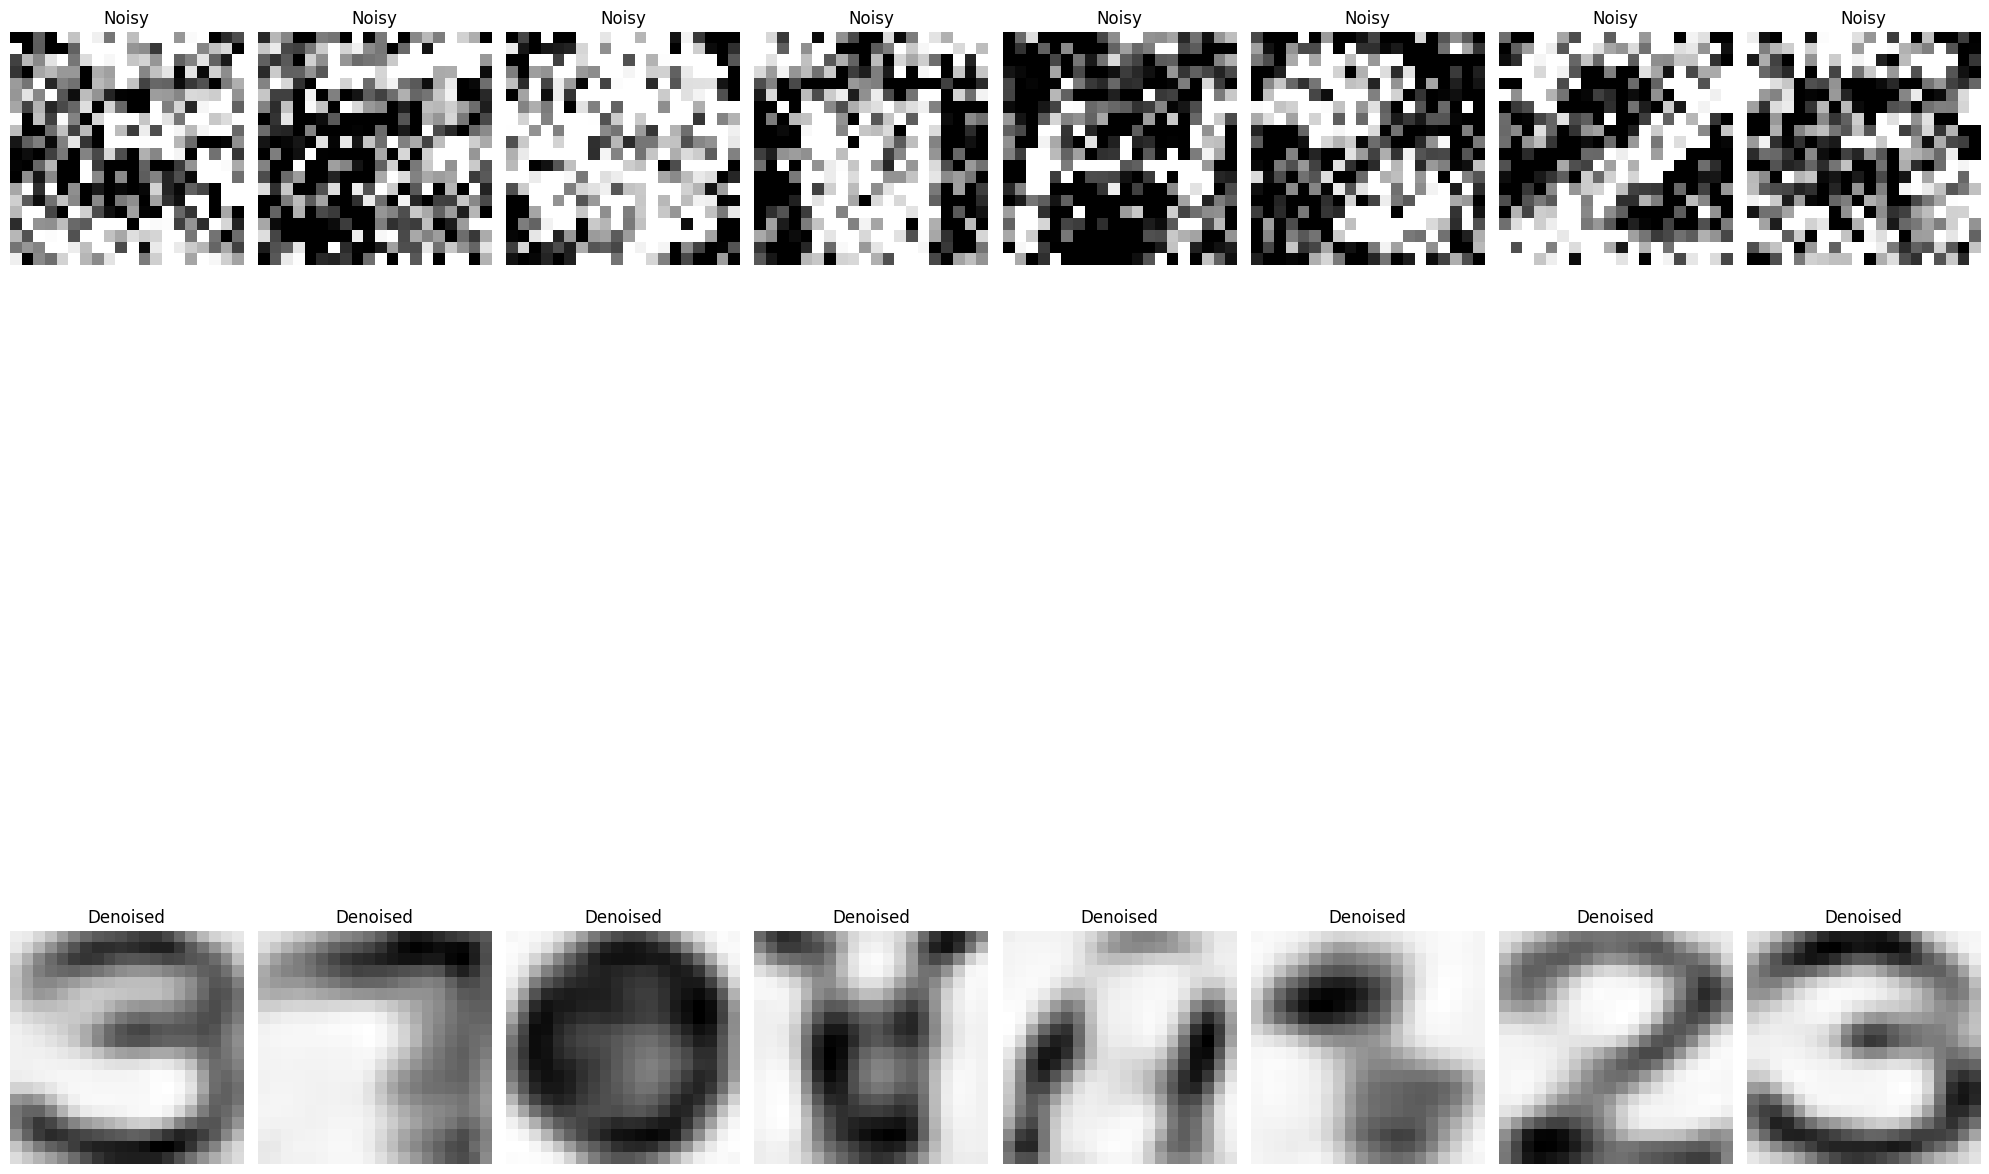

In [21]:
# method to plot showing noisy and denoised versions of some input
def compare(model, test_loader, num_images):
    model.eval()
    plt.figure(figsize=(20, 25))
    with torch.no_grad():
        for i, (noisy_images, clean_images) in enumerate(test_loader):
            if i >= num_images:
                break
                # draws original image
            noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
            outputs = model(noisy_images)
            ax = plt.subplot(2, num_images, i+1)
            plt.imshow(noisy_images[0, 0].cpu().numpy(), cmap='gray', interpolation=None)
            plt.title('Noisy')
            plt.axis('off')

            # reconstructed version
            ax = plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(outputs[0, 0].cpu().numpy(), cmap='Greys', interpolation=None)
            plt.title('Denoised')
            plt.axis('off')
    plt.tight_layout()
    plt.show()


compare(autoencoder, test_loader, num_images=8)


Our Denoiser NN seems to be working well for taking out 'noise' from input and still procuding a coherent clean output.